# Example of loading, processing and plotting RACMO output in PANGEO

Several fields of output from the regional climate model RACMO for antarctica version ERAINx_RACMO2.4.1 were combined, convereted to zarr and uploaded to a google bucket, following instructions here: https://pangeo.io/data.html.

This notebook shows how to open, process and plot these data in pangeo.

J. Kingslake, May 20 2020


In [3]:
import xarray as xr
import dask
import zarr
import fsspec
xr.set_options(display_style="html");

This code block is created by starting a new cluster in the panel on the left. 


In [4]:
from dask.distributed import Client

client = Client("tcp://10.32.16.24:36013")
client

Client Scheduler: tcp://10.32.16.24:36013 Dashboard: /user/0000-0002-2065-9473/proxy/8787/status,Cluster Workers: 28 Cores: 56 Memory: 322.00 GB


Load the zarr file from the pangeo-pgc googlebucket. 

In [5]:
RACMO = xr.open_zarr(fsspec.get_mapper('gs://pangeo-pgc/tskin_snowmelt_precip6'))


Take a look at the resulting xarray dataset. It hasn't been loaded into memory, it is just  a pointer to the data in the googlebucket.
The main variables are skin temeprature (tskin), snow melt rate (snowmelt), and precipitation (precip).

In [6]:
RACMO

,Array,Chunk
Bytes,503.04 kB,200 B
Shape,"(240, 262)","(5, 5)"
Count,2545 Tasks,2544 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,503.04 kB,200 B
Shape,"(240, 262)","(5, 5)"
Count,2545 Tasks,2544 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


Check the size of the skin temperature data array.

In [11]:
RACMO.tskin.nbytes / 1e9

3.73582656

Plot the skin temperature on the fitst day of the simulation as a function of space. This takes a few seconds becuase it needs to transferthe data to the cluster. 

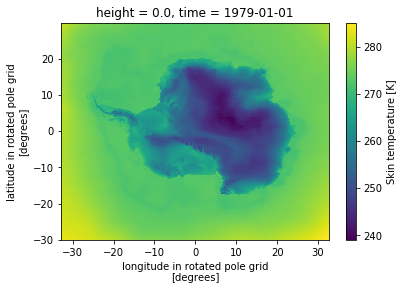

In [14]:
RACMO.tskin.isel(time=0).plot()

Compute something that involves every part of the tskin array - the minimum temperature ever reached over the simulation in each grid cell.

In [15]:
min_tskin = RACMO.min(dim='time')

Nothing has happened because nothing was computed yet - it is delayed until you ask it to compute it. 

In [18]:
min_tskin

,Array,Chunk
Bytes,503.04 kB,200 B
Shape,"(240, 262)","(5, 5)"
Count,2545 Tasks,2544 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,503.04 kB,200 B
Shape,"(240, 262)","(5, 5)"
Count,2545 Tasks,2544 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


Only when you ask it to compute, does it compute the minimum in each grid cell It transfers the data to each worker in the cluster individually and does the computation in parallel across the workers.

In [20]:
min_tskin.compute()

<xarray.Dataset>
Dimensions:       (bnds: 2, height: 1, rlat: 240, rlon: 262)
Coordinates:
  * height        (height) float64 0.0
    lat           (rlat, rlon) float64 -46.75 -46.92 -47.09 ... -47.24 -47.07
    lon           (rlat, rlon) float64 -126.9 -127.1 -127.3 ... 53.03 53.23
  * rlat          (rlat) float64 -30.0 -29.75 -29.5 -29.25 ... 29.25 29.5 29.75
  * rlon          (rlon) float64 -32.75 -32.5 -32.25 -32.0 ... 32.0 32.25 32.5
Dimensions without coordinates: bnds
Data variables:
    assigned      int32 1
    date_bnds     (bnds) int32 19790101 19790102
    dtg           int32 1979010100
    hms_bnds      (bnds) int32 0 0
    precip        (height, rlat, rlon) float32 -1.5382449e-07 ... -1.3598721e-07
    rotated_pole  float32 9.96921e+36
    snowmelt      (height, rlat, rlon) float32 -1.2505035e-07 ... -1.2505035e-07
    time_bnds     (bnds) datetime64[ns] 1979-01-01 1979-01-02
    tskin         (height, rlat, rlon) float32 279.3108 279.22485 ... 275.16748

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1025, in _reconnect
    await self._close()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures